In [92]:
 # Some general imports
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import numpy as np

# Custom code (see ngram_lm.py and utils.py)
from ngram_lm import ngrams, UnsmoothedLM, characters_from_files, words_from_files
from utils import plot_output


# Probabilistic Text Generator


Define a probabilistic model of sentences based on the chain rule of probabilities.

$$P(The, cat, sat, on, the, mat, .) = $$


$$P(The | \text{<}bos\text{>}) *$$


$$ P(cat | \text{<}bos\text{>} , The) * $$ 


$$ \ldots$$


$$ P(. | \text{<}bos\text{>} , \ldots , mat)$$

# How do we generate text from a probabilistic model of sentences?

$$w_1 \sim P(w|\text{<}bos\text{>})$$

$$w_2 \sim P(w|\text{<}bos\text{>}, w_1)$$

$$\ldots$$

$$w_n \sim P(w|\text{<}bos\text{>}, w_1, ..., w_{n-1})$$

# Ngram-based (unsmoothed) Language Model

- Straight-forward way of implementing a *probabilistic text generator*
- A Language Model that estimates the output probability distribution on the basis of n-gram statistics
- (ref. Y. Goldberg's http://nbviewer.jupyter.org/gist/yoavg/d76121dfde2618422139)



## How to fit the model:

- Compute ngrams
- Count number of times each ngram appears in front of each vocabulary item
- Normalize into probabilities

In [26]:
# Uncomment this block to get some real shakespeare data
#!wget http://cs.stanford.edu/people/karpathy/char-rnn/shakespeare_input.txt
with open('shakespeare_input.txt', 'r') as f:
    corpus = [c for sent in f for c in sent]
    
print(''.join(corpus[:10]))

First Citi


### Compute n-grams

In [11]:
# `ngram`: function defined in ngram_lm.py that computes ngrams over input sequences
for i in ngrams(corpus[:10], 3):
    print(i)

('<pad>', '<pad>', 'F')
('<pad>', 'F', 'i')
('F', 'i', 'r')
('i', 'r', 's')
('r', 's', 't')
('s', 't', ' ')
('t', ' ', 'C')
(' ', 'C', 'i')
('C', 'i', 't')
('i', 't', 'i')


### Count prefix/target co-occurrences and normalize into probabilities

In [13]:
model = defaultdict(Counter)

# count prefix/target co-occurrences
for ngram in ngrams(corpus, 5):
    # use first n-1 characters as prefix, last character as target
    *prefix, target = ngram
    model[tuple(prefix)][target] += 1 # accumulate counts
    
# normalize into probability distribution
for prefix, counter in model.items():
    total = sum(counter.values())
    model[prefix] = [(target, counts/total) for target, counts in counter.items()]

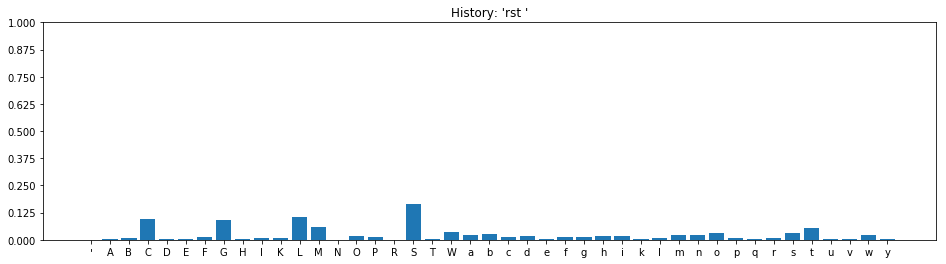

In [47]:
# Visualize output distribution by querying the model and displaying output probability distribution

# random ngram from the corpus
prefix = 'rst ' 
targets, probs = zip(*model[tuple(prefix)])
# function from utils.py to plot an output distribution
ax = plot_output(targets, probs, prefix)

# RNN-based Language Model

- Exploit RNN capability to model forward information flow to condition the output probability on theoretically all previous steps
- While ngram model is limited in scope by the "markov" assumption that any character is only conditioned by the previous n characters, an RNN-based model is able to capture much longer dependencies

In [15]:
from IPython.display import SVG, display
display(SVG('./img/rnnlm.svg'))

In [2]:
# `seqmod` is our custom library to train RNN-based models
# To run this cell you'll need to make sure you have it
#   1. clone or download the package from "https://github.com/emanjavacas/hierarchical-lm"
#   2. put it on your python path
#       import sys; sys.path.append("/path/to/hierarchical-lm/")
path = '/home/manjavacas/code/python/hierarchical-lm/'
import sys
if path not in sys.path:
    sys.path.append(path)

from hierarchical_lm import loader
charlm, encoder = loader.model_loader('models/CharLanguageModel.2019-03-26+10:56:35')
print(charlm)

CharLanguageModel(
  (embs): Embedding(72, 200, padding_idx=3)
  (rnn): ModuleList(
    (0): LSTM(200, 675)
    (1): LSTM(675, 675)
    (2): LSTM(675, 675)
  )
  (proj): Linear(in_features=675, out_features=72, bias=True)
)


/home/manjavacas/code/python/hierarchical-lm/hierarchical_lm/char_model.py:260: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(logits[-1])


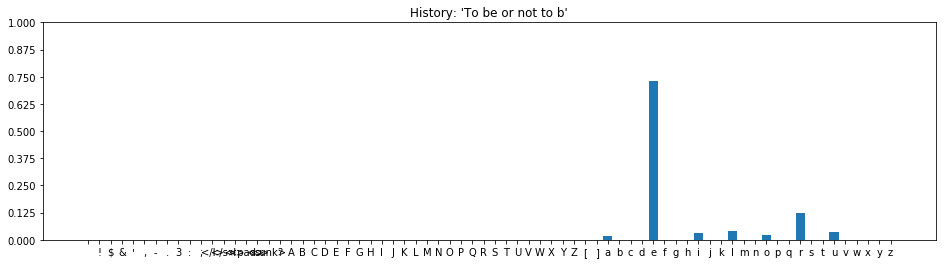

In [5]:
prefix = 'To be or not to b'
targets, probs = charlm.get_next_probability(encoder, [prefix.split()])
plot_output(targets, probs[0], prefix)

# Temperature: tweaking the output distribution to enforce/penalize diversity

- Generated text can often be boring, dull but also too non-sensical
- We can tweak diversity by boosting or reducing model's confidence
- This is achieve by artifically skewing or flattening the output distribution

Given the model output at a given step:

$$p=P(w|The,cat,sat,on,the)$$ 

where p is a probability distribution over the vocabulary: 

$$p = \{p_1, p_2, ..., p_v\}$$


Define the transformed probability distribution by applying an element-wise non-linear function depending on user-defined parameter $\tau$ (usually in range 0-2):

$$p^{\prime}_i = p_i^{(1/\tau)}$$

and renormalizing into a probability distribution by softmax:

$$p^{\tau}_i = \frac{p_i^{\prime}}{\sum_{j=1}^v p_j^{\prime}}$$


### Visualizing the effect of temperature

In [94]:
# fit a model on shakespeare data (charlm model is trained on same dataset)
# UnsmoothedLM is defined in ngram_lm.py
lm = UnsmoothedLM(5).fit(characters_from_files('shakespeare_input.txt'))

# auxiliary functions to query the ngram model
def query_lm(model=lm, seed='irst'):
    """Query a random probability from the NGRAM lm model"""
    targets, probs = zip(*model.model[tuple(seed)])
    probs = np.array(probs)
    return targets, probs, seed

# auxiliary function to query the rnn model
def query_rnnlm(model=charlm, seed='Hi there'):
    targets, probs = model.get_next_probability(encoder, [seed.split()])
    probs = probs[0] # drop batch dim
    return targets, probs, seed

# some imports for interactive viz
from ipywidgets import interact, ToggleButton

In [10]:
targets, probs, prefix = query_lm(seed="not t") # from not to be...

def plot(temperature=1.0):
    # sort alphabetically
    xticks, y = zip(*sorted(zip(targets, probs), key=lambda t: t[0]))
    x = np.arange(len(targets))
    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_subplot(111)
    ax.bar(x, lm.apply_temperature(np.array(y), temperature))
    ax.set_title(''.join(prefix))
    ax.set_xticks(x)
    ax.set_xticklabels(xticks)
    ax.set_yticks(np.linspace(0, 1, 9))
    return ax

interact(plot, temperature=(1e-2, 3))

interactive(children=(FloatSlider(value=1.0, description='temperature', max=3.0, min=0.01), Output()), _dom_cl…

<function __main__.plot>

In [11]:
targets, probs, prefix = query_rnnlm(seed="To be or not to b")

def plot(temperature=1.0):
    # sort alphabetically
    xticks, y = zip(*sorted(zip(targets, probs), key=lambda t: t[0]))
    x = np.arange(len(targets))
    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_subplot(111)
    ax.bar(x, lm.apply_temperature(np.array(y), temperature))
    ax.set_title(''.join(prefix))
    ax.set_xticks(x)
    ax.set_xticklabels(xticks)
    ax.set_yticks(np.linspace(0, 1, 9))
    return ax

interact(plot, temperature=(1e-2, 3))

/home/manjavacas/code/python/hierarchical-lm/hierarchical_lm/char_model.py:260: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(logits[-1])


interactive(children=(FloatSlider(value=1.0, description='temperature', max=3.0, min=0.01), Output()), _dom_cl…

<function __main__.plot>

# Visualizing model certainty while processing text

We are using code inside `./viz/` which is based on code by @karpathy (http://karpathy.github.io/2015/05/21/rnn-effectiveness/).

To run the following visualization you first have to go into `./viz/` and run `python server.py`.

In [5]:
from viz.client import register_data # function to compute per-charater scores and send them to the viz server

# some random text by Shakespeare
raw_text = """
We are accounted poor citizens, the patricians good. What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I speak this in hunger for bread, not in thirst for revenge.
"""
text = ' '.join(raw_text.split()) # normalize whitespace
text = text.strip() # remove trailing space

In [9]:
tok_text = """
We are accounted poor citizens , the patricians good . What authority surfeits on would relieve us : if they
would yield us but the superfluity , while it were wholesome , we might guess they relieved us humanely ;
but they think we are too dear : the leanness that afflicts us , the object of our misery , is as an
inventory to particularise their abundance ; our sufferance is a gain to them Let us revenge this with
our pikes , ere we become rakes : for the gods know I speak this in hunger for bread , not in thirst for revenge .
"""
tok_text = ' '.join(tok_text.split()) # normalize whitespace
tok_text = tok_text.strip() # remove trainling space

In [95]:
# visualize assigned probability per character as per Ngram LM
targets, probs = lm.get_probabilities(raw_text, score_entropy=True)
register_data(targets, probs)

True

In [52]:
# visualize hidden activations from RNN
targets, output = charlm.get_activations(encoder, [text.split()])
register_data(targets[0], output[0])

True

In [3]:
from hierarchical_lm import loader
wordlm, encoder = loader.model_loader('./models/RNNLanguageModel.2019-03-26+17:02:48')
print(wordlm)

RNNLanguageModel(
  (wembs): Embedding(10004, 100, padding_idx=3)
  (cembs): Embedding(71, 100, padding_idx=3)
  (cembs_rnn): CustomBiLSTM(
    (fwd): CustomLSTM(
      (cell): CustomLSTMCell(100, 50)
    )
    (bwd): CustomLSTM(
      (cell): CustomLSTMCell(100, 50)
    )
  )
  (rnn): ModuleList(
    (0): LSTM(200, 640)
    (1): LSTM(640, 640)
  )
  (proj): Linear(in_features=640, out_features=10004, bias=True)
)


In [10]:
targets, probs = wordlm.get_probabilities(encoder, [tok_text.split()])
register_data(targets[0], probs[0], word=True)

True

In [ ]:
targets, output = wordlm.get_activations(encoder, [tok_text.split()])
register_data(targets[0], output[0], word=True)

In [69]:
# Interesting activation (non-exhaustive)

# 137, 836, 102: word boundary
# 806: word & sent boundary
# 743: reset at the beginning
# 287: end of verse
# 196: verbs?
# 2, 22, 69: verse boundary
# 41: word & verse boundary
# 162: strange pattern